In [21]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import utils, build_features_final, build_features
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
# train_gmx = pd.read_csv(r'data/processed/Train_GaussianMixture.csv')
# train_knn = pd.read_csv(r'data/processed/Train_KNN.csv')
# # add_train = pd.read_csv(r'data/processed/robust.csv')
# train_data = pd.concat([train_data, train_gmx, train_knn], axis=1)
train_data = build_features_final.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
# test_gmx = pd.read_csv(r'data/processed/Test_GaussianMixture.csv')
# test_knn = pd.read_csv(r'data/processed/Test_KNN.csv')
# test_data = pd.concat([test_data, test_gmx, test_knn], axis=1)
test_data = build_features_final.create_derived_features(test_data)

# train_data = utils.outlier_z_score_filter_df(train_data, threshold=3.5)
train_type = train_data['type']
test_type = test_data['type']

train_data = train_data.drop('type', axis=1)
test_data = test_data.drop('type', axis=1)

train_data = train_data.ewm(span=12).mean()
test_data = test_data.ewm(span=12).mean()

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

scaled_train_data_df = scaled_train_data.copy()
scaled_test_data_df = scaled_test_data.copy()

scaled_train_data['type'] = train_type
scaled_test_data['type'] = test_type

grouped_train = scaled_train_data.groupby('type')

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", "air_to_motor_ratio"]

anomaly = []
all_threshold = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['type'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    n_features = train_group.shape[1]
    print(n_features)
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.DeepAutoEncoder(input_dim=n_features, latent_dim=64)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_threshold = evaluation(train_loader, model)
    test_prediction, test_threshold = evaluation(test_loader, model, min(train_threshold))

    anomaly.append(test_prediction)
    all_threshold.append(test_threshold)
    print(f"finish {group_name}type")

all_threshold = np.concatenate(all_threshold)
anomaly = np.concatenate(anomaly)
submission = prediction_to_csv(anomaly)

14
Epoch [0/500], Loss: 0.0667117
Epoch [100/500], Loss: 0.0000409
Epoch [200/500], Loss: 0.0000114
Epoch [300/500], Loss: 0.0000066
Epoch [400/500], Loss: 0.0000043
finish 0type
14
Epoch [0/500], Loss: 0.0624426
Epoch [100/500], Loss: 0.0000332
Epoch [200/500], Loss: 0.0000161
Epoch [300/500], Loss: 0.0000100
Epoch [400/500], Loss: 0.0000064
finish 1type
14
Epoch [0/500], Loss: 0.1474887
Epoch [100/500], Loss: 0.0001281
Epoch [200/500], Loss: 0.0000296
Epoch [300/500], Loss: 0.0000103
Epoch [400/500], Loss: 0.0000072
finish 2type
14
Epoch [0/500], Loss: 0.1309588
Epoch [100/500], Loss: 0.0000487
Epoch [200/500], Loss: 0.0000187
Epoch [300/500], Loss: 0.0000117
Epoch [400/500], Loss: 0.0000085
finish 3type
14
Epoch [0/500], Loss: 0.0788695
Epoch [100/500], Loss: 0.0000768
Epoch [200/500], Loss: 0.0000348
Epoch [300/500], Loss: 0.0000309
Epoch [400/500], Loss: 0.0000290
finish 4type
14
Epoch [0/500], Loss: 0.0684187
Epoch [100/500], Loss: 0.0000417
Epoch [200/500], Loss: 0.0000111
Epoch

In [22]:
test_data['label'] = anomaly
test_data['treshold'] = all_threshold
def no_out(test_data):
    test7342 = test_data[7342:7361]
    
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no
yes, no = no_out(test_data)

In [23]:
yes

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,motor_hp,air_flow_pressure,current_by_airflow,...,air_to_motor_ratio,air_to_power_ratio,mechanical_efficiency,air_density,air_mass_flow,air_inflow_efficiency1,air_inflow_efficiency2,motor_current_efficiency,label,treshold


In [24]:
no

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,motor_hp,air_flow_pressure,current_by_airflow,...,air_to_motor_ratio,air_to_power_ratio,mechanical_efficiency,air_density,air_mass_flow,air_inflow_efficiency1,air_inflow_efficiency2,motor_current_efficiency,label,treshold
7342,1.999734,47.063280,0.7,26.475053,2152.677207,63.919008,3.228249,30.0,1.399814,13.313459,...,0.000927,0.023543,34.856192,0.289458,0.569403,0.014607,9.513258,3.840662,1,0.999155
7343,2.032083,47.396622,0.7,26.798891,2181.188406,64.236084,3.239287,30.0,1.422458,13.254793,...,0.000930,0.023526,35.393609,0.288993,0.579192,0.014564,9.611218,3.819680,1,0.999144
7344,2.093301,48.140218,0.7,27.523677,2242.236343,64.913610,3.268628,30.0,1.465311,13.210529,...,0.000932,0.023366,36.190548,0.286811,0.592822,0.014436,9.720463,3.780261,1,0.999324
7345,2.071255,47.789416,0.7,27.180034,2215.584598,64.617670,3.250377,30.0,1.449878,13.173406,...,0.000933,0.023537,36.076837,0.288717,0.591379,0.014517,9.736963,3.795669,1,0.999616
7346,2.194138,49.358736,0.7,28.712337,2342.263891,66.025720,3.318012,30.0,1.535897,13.137615,...,0.000935,0.023138,37.380317,0.283673,0.613401,0.014253,9.861012,3.721252,1,0.999485
7347,2.051963,47.423546,0.7,26.818131,2188.377138,64.315610,3.230625,30.0,1.436374,13.103119,...,0.000937,0.023910,35.699217,0.292974,0.586269,0.014712,9.637850,3.832419,1,0.999807
7348,2.160892,49.721462,0.7,29.196880,2360.780656,66.231670,3.355144,30.0,1.512624,13.443999,...,0.000921,0.022718,35.965063,0.279664,0.583739,0.014120,9.524165,3.729384,1,0.997009
7349,2.031524,47.842776,0.7,27.338898,2213.122093,64.591413,3.266661,30.0,1.422067,13.371029,...,0.000924,0.023490,34.616521,0.288779,0.562759,0.014556,9.373453,3.831883,1,0.998254
7350,2.188213,49.779272,0.7,29.214453,2370.180233,66.335811,3.348713,30.0,1.531749,13.307895,...,0.000927,0.022999,36.362445,0.282534,0.592637,0.014228,9.557642,3.737231,1,0.998070
7351,2.311565,51.291691,0.7,30.678383,2493.075581,67.701071,3.411988,30.0,1.618095,13.253323,...,0.000930,0.022620,37.775394,0.277673,0.616892,0.013969,9.713886,3.662335,1,0.998489


Chunk 0: 171/1296 labels with value 1


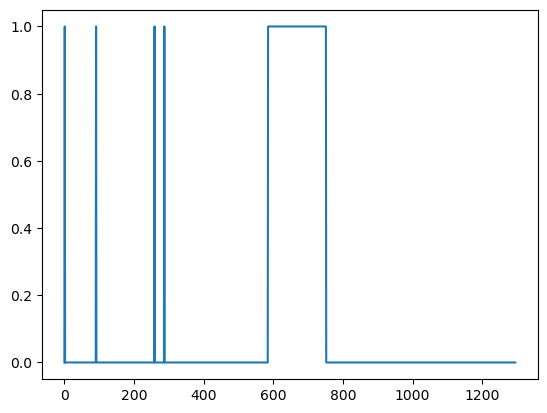

Chunk 1: 9/1107 labels with value 1


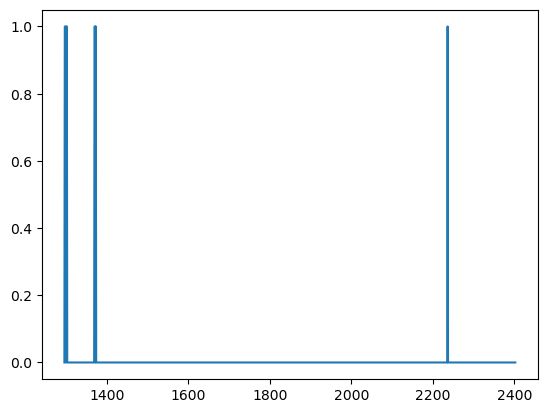

Chunk 2: 113/1098 labels with value 1


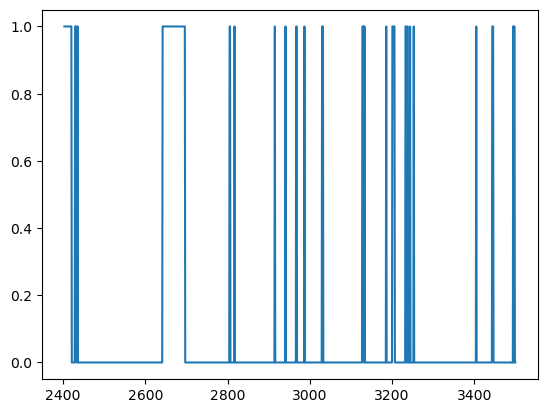

Chunk 3: 75/918 labels with value 1


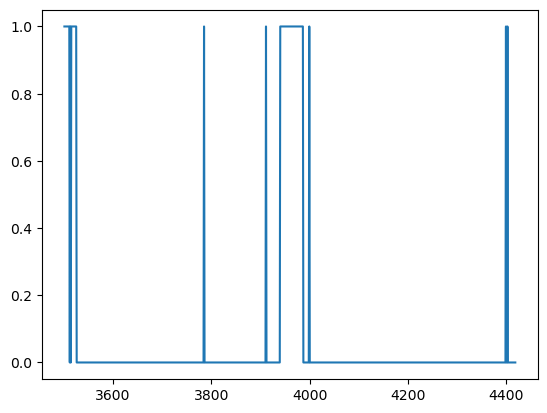

Chunk 4: 69/918 labels with value 1


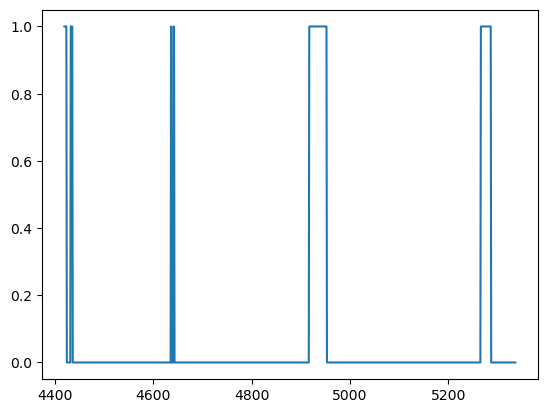

Chunk 5: 52/746 labels with value 1


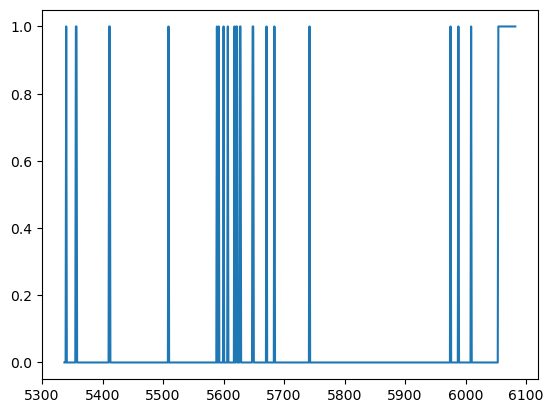

Chunk 6: 258/748 labels with value 1


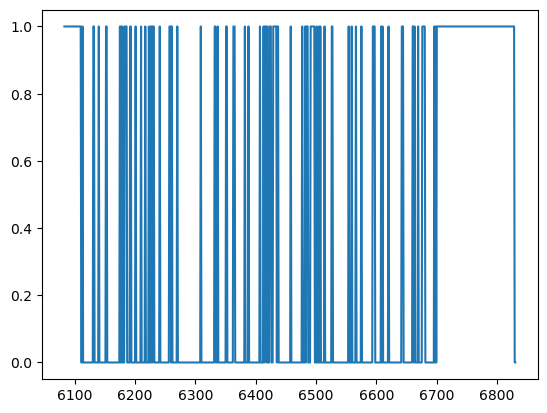

Chunk 7: 32/558 labels with value 1


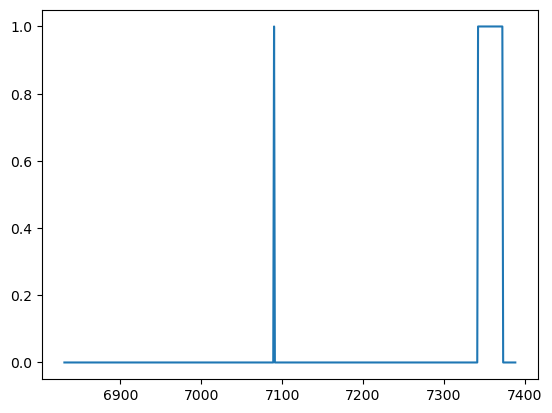

In [25]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels}/{len(chunk)} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)